In [ ]:
# Source: https://towardsdatascience.com/reinforcement-learning-with-ohttps://github.com/openai/gym/wiki/Environmentspenai-d445c2c687d2
#
# https://gym.openai.com/envs/#classic_control
# https://github.com/openai/gym/wiki/Environments

# conda install -n py37 gym[atari] -c conda-forge
# conda install -n py37 gym[all] -c conda-forge
# conda install -n py37 atari_py -c conda-forge
# conda install -n py37 pybox2d -c conda-forge

# Acrobot-v1
# CartPole-v0
# MountainCar-v0
# MountainCarContinuous-v0

# Pong-v0
# MsPacman-v0

# CarRacing-v0

# FrozenLake8x8-v0

# DE AQUI

In [ ]:
# https://deeplizard.com/learn/video/a-SnJtmBtyA
# https://www.youtube.com/watch?v=nyjbcRQ-uQ8&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv

# https://pythonprogramming.net/deep-q-learning-dqn-reinforcement-learning-python-tutorial/
# https://www.freecodecamp.org/news/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8/
# https://simoninithomas.github.io/Deep_reinforcement_learning_Course/
# https://lilianweng.github.io/lil-log/2018/05/05/implementing-deep-reinforcement-learning-models.html

In [ ]:
import numpy as np
import random
import gym
import time
import tensorflow as tf

from itertools import count
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, CategoryEncoding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
# Create environment and see length of S and A
env = gym.make('FrozenLake-v0', is_slippery=False)

in_shape = env.observation_space.n # Size of state space
print(f"State space length: {in_shape}")
out_shape = env.action_space.n         # Size of action space
print(f"Action space length: {out_shape}")

env.close()

State space length: 16
Action space length: 4


In [ ]:
# Run N times with no intelligence: show table of states
env = gym.make('FrozenLake-v0', is_slippery=False)

state = env.reset()
print(f"t = {0:2d}; state: {state}")
for t in range(1, 4):
  env.render()
  action = env.action_space.sample()
  state, reward, done, info = env.step(action)
  print(f"t = {t:2d}; state: {state}; action:{action}; reward:{reward} \n")

env.close()

t =  0; state: 0

SFFF
FHFH
FFFH
HFFG
t =  1; state: 0; action:0; reward:0.0 

  (Left)
SFFF
FHFH
FFFH
HFFG
t =  2; state: 4; action:1; reward:0.0 

  (Down)
SFFF
FHFH
FFFH
HFFG
t =  3; state: 4; action:0; reward:0.0 



In [ ]:
# Run N times with no intelligence: print list with state, action and reward.
env = gym.make('FrozenLake-v0', is_slippery=False)

state = env.reset()
print(f"t = {0:2d}; state: {state}")
for t in range(1, 20):
  action = env.action_space.sample()
  state, reward, done, info = env.step(action)
  print(f"t = {t:2d}; state: {state}; action:{action}; reward:{reward}")

env.close()

t =  0; state: 0
t =  1; state: 0; action:3; reward:0.0
t =  2; state: 4; action:1; reward:0.0
t =  3; state: 4; action:0; reward:0.0
t =  4; state: 8; action:1; reward:0.0
t =  5; state: 8; action:0; reward:0.0
t =  6; state: 4; action:3; reward:0.0
t =  7; state: 4; action:0; reward:0.0
t =  8; state: 5; action:2; reward:0.0
t =  9; state: 5; action:0; reward:0
t = 10; state: 5; action:1; reward:0
t = 11; state: 5; action:2; reward:0
t = 12; state: 5; action:0; reward:0
t = 13; state: 5; action:1; reward:0
t = 14; state: 5; action:1; reward:0
t = 15; state: 5; action:0; reward:0
t = 16; state: 5; action:2; reward:0
t = 17; state: 5; action:1; reward:0
t = 18; state: 5; action:3; reward:0
t = 19; state: 5; action:3; reward:0


In [ ]:
def create_agent():
  '''Definition of agent'''
  model = Sequential()
  model.add(Input(shape=(1)))
  model.add(CategoryEncoding(num_tokens=in_shape, output_mode="one_hot"))
  model.add(Dense(out_shape, activation='softmax'))
  return model

Number of parameters: 68


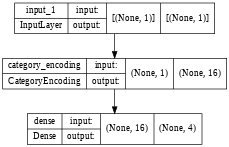

In [ ]:
agent = create_agent()
print(f"Number of parameters: {agent.count_params():,}")
plot_model(agent, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

# Aux functions

In [ ]:
def sample_action(state, eps):
  ''' Generate an action.
      Given the current exploration rate (defined by the number of samples taken
      so far, 'global samples_taken'), the action can be generated either
      by exploration (random) or exploitation (using current knowledge,
      i.e., current model and current state, 'state').
  '''
  if np.random.uniform() > eps:
    action = np.argmax(agent_policy.predict(np.array([state])))
  else:
    action = env.action_space.sample()
  return action

In [ ]:
def init_replay_mem(memory_len):
  ''' Pre-initialize replay memory for efficiency purposes.
  '''
  experience = {"state": 0, "action": 0, "reward": 0, "next_state": 0, "done": False}

  memory = []
  for _ in range(memory_len):
    memory.append(experience.copy())
    
  return memory

In [ ]:
def push_experience(experience, push_count, memory_len):
  '''
  Stores experience in replay memory.
  Values of experience are encapsulated into a dictionary.
  Append if replay memory has not yet reached max length, or
  replace oldest register.
  '''
  replay_mem[push_count % memory_len] = experience

In [ ]:
def decouple_batch(batch):
  ''' Decouple a batch of experiences into numpy arrays
  '''
  states, actions, rewards, next_states, dones = zip(*map(dict.values, batch))
  return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# Create and train model

In [ ]:
# Initialize agent (policy and target)
agent_policy = create_agent()
agent_policy.compile(optimizer='adam', loss='categorical_crossentropy')

agent_target = create_agent()
agent_target.set_weights(agent_policy.get_weights())

In [ ]:
# Exploration/exploitation rate parameters
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.01

In [ ]:
# Parameters
n_episodes = 2_000
batch_size = 128
memory_len = 20_000
gamma = 0.98
update_rate = 10

In [ ]:
# Initialize variables
replay_mem = init_replay_mem(memory_len)
eps = EPS_START
push_count = 0
n_wins, max_wins = 0, 0 # Count consecutive wins
loss = np.nan

In [ ]:
# Train - initialize environment
env = gym.make('FrozenLake-v0', is_slippery=True)
for episode in range(n_episodes):
  start_time = time.time()

  # Reset environment and get initial state
  state = env.reset()
  for t_step in count():
    # Simulate one time step
    action = sample_action(state, eps)                # Select an action with prob eps
    next_state, reward, done, info = env.step(action) # Evaluate sampled action

    # Adjust reward (custom reward function)
    if done and reward == 0:    # Lost
      reward = -10.0
    elif done and reward == 1:  # Win
      reward = 100.0 / (t_step + 1)
    else:                       # Just still alive
      reward = 0.1 / (t_step + 1)

    # Store experience
    experience = {"state": state, "action": action, "reward": reward,
                  "next_state": next_state, "done": done}
    #print(experience)
    push_experience(experience, push_count, memory_len)    # Push new experience into replay memory
    push_count += 1                                        # Update count of pushes into memory
    state = next_state                                     # Update state as given by the last action

    # Sampling from replay memory
    if push_count >= batch_size:
      # sample a random batch from replay memory (from populated part only)
      samp_size = min(push_count, memory_len)
      batch = random.sample(replay_mem[:samp_size], batch_size)
      batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = decouple_batch(batch)
      
      # Compute q-values for current and next state, and update for the chosen action
      q_vals = agent_policy.predict(batch_states)
      q_vals_next = agent_target.predict(batch_next_states)
      
      # Updte Q-values by Bellman equation and normalize probabilities
      q_vals[tuple(range(batch_size)), tuple(batch_actions)] = batch_rewards + gamma * np.max(q_vals_next, axis=1)
      q_vals = tf.nn.softmax(q_vals)
    
      # Retrain network
      loss = agent_policy.train_on_batch(batch_states, q_vals)

    # Check for episode termination
    if done:
      break

  # Update probability of exploration/exploitation for next iteration
  eps = EPS_END + (EPS_START - EPS_END) * np.exp(-EPS_DECAY * episode)
  #eps *= (1-EPS_DECAY)
  #if eps < EPS_END:
  #  eps = EPS_START

  # Update target network
  if episode % update_rate == 0:
    agent_target.set_weights(agent_policy.get_weights())
  
  # Print episode's info
  print(f"Episode:{episode+1:4d}/{n_episodes} --", end=' ')
  if reward <= 0:
    print(" failed  ", end=' ')
    n_wins = 0
  elif reward > 0:
    print("*success*", end=' ')
    n_wins += 1
  max_wins = max(max_wins, n_wins)

  elapsed = time.time() - start_time
  print(f"(wins={n_wins:2d}/{max_wins:2d})", end=' ')
  print(f"in {t_step+1:3d} time steps. Ends up @state {state:2d}. eps={eps:.3f}({push_count:6d}), loss={loss:.4f}, time={elapsed:.2f} s")

env.close()

Episode:   1/2000 --  failed   (wins= 0/ 0) in  19 time steps. Ends up @state  7. eps=1.000(    19), loss=nan, time=0.01 s
Episode:   2/2000 --  failed   (wins= 0/ 0) in  16 time steps. Ends up @state 12. eps=0.990(    35), loss=nan, time=0.01 s
Episode:   3/2000 --  failed   (wins= 0/ 0) in  13 time steps. Ends up @state  5. eps=0.980(    48), loss=nan, time=0.72 s
Episode:   4/2000 --  failed   (wins= 0/ 0) in   4 time steps. Ends up @state  5. eps=0.971(    52), loss=nan, time=0.10 s
Episode:   5/2000 --  failed   (wins= 0/ 0) in  14 time steps. Ends up @state 12. eps=0.961(    66), loss=nan, time=0.00 s
Episode:   6/2000 --  failed   (wins= 0/ 0) in   4 time steps. Ends up @state  5. eps=0.952(    70), loss=nan, time=0.00 s
Episode:   7/2000 --  failed   (wins= 0/ 0) in  10 time steps. Ends up @state  5. eps=0.942(    80), loss=nan, time=0.00 s
Episode:   8/2000 --  failed   (wins= 0/ 0) in   4 time steps. Ends up @state  5. eps=0.933(    84), loss=nan, time=0.00 s
Episode:   9/200

In [ ]:
# Validate on a series of several consecutive runs
env = gym.make('FrozenLake-v0', is_slippery=True)
wins = 0
max_wins = 0
for i in range(30):
  state = env.reset()
  done = False
  for ind_step in count():
    #env.render()                    # Uncomment to see game running
    action = np.argmax(agent_policy.predict(np.array([state])))
    state, reward, done, info = env.step(action)
    if done:
        break

  print(f"Episode: {i+1:2d}", end=' ')
  if reward == 1:
    print("Win!")
    wins += 1
  else:
    print("Lose!")
    wins = 0
  max_wins = max(max_wins, wins)
env.close()

print('Max number of consecutive wins: {}'.format(max_wins))

Episode:  1 Win!
Episode:  2 Win!
Episode:  3 Lose!
Episode:  4 Lose!
Episode:  5 Win!
Episode:  6 Lose!
Episode:  7 Lose!
Episode:  8 Win!
Episode:  9 Win!
Episode: 10 Win!
Episode: 11 Win!
Episode: 12 Lose!
Episode: 13 Lose!
Episode: 14 Lose!
Episode: 15 Win!
Episode: 16 Win!
Episode: 17 Lose!
Episode: 18 Lose!
Episode: 19 Win!
Episode: 20 Lose!
Episode: 21 Win!
Episode: 22 Lose!
Episode: 23 Win!
Episode: 24 Lose!
Episode: 25 Lose!
Episode: 26 Lose!
Episode: 27 Win!
Episode: 28 Lose!
Episode: 29 Win!
Episode: 30 Win!
Max number of consecutive wins: 4


In [ ]:
# See output for one single episode
env = gym.make('FrozenLake-v0', is_slippery=False)
state = env.reset()
tot_r, done = 0, False
for ind_step in count():
    env.render()                    # Uncomment to see game running
    action = np.argmax(agent_policy.predict(np.array([state])))
    state, reward, done, info = env.step(action)
    tot_r += reward
    if done:
        break
env.render()        
env.close()
print('Game ended! Total reward: {}'.format(tot_r))


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Game ended! Total reward: 1.0


In [ ]:
# Save trained model for future use
#net_policy.save("agent_policy.h5")